<center>
    <h1> ILI285 - Computación Científica I  / INF285 - Computación Científica </h1>
    <h2> Tarea 2 </h2>
    <h2> [S]cientific [C]omputing [T]eam </h2>
</center>

_Marzo 2017_

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline

# Tabla de Contenidos
* [1.- Objetivos](#obj)
* [2.- Hints](#hints)
* [3.- Aritmética Punto Flotante](#aritmetica)
* [4.- Pérdida de Significancia](#perdida)
* [5.- Instrucciones](#instrucciones)

<div id='obj' />
# 1. Objetivos

- Observar y aplicar conceptos de aritmética de punto flotante bajo el standard <i> IEEE 754 floating points. </i>http://ieeexplore.ieee.org/document/30711/
- Analizar y comprender el origen del fenómeno de pérdida de significancia y aplicar técnicas para contrarrestar este fenómeno.

In [125]:
import bitstring as bs

def pack_binary(f):
    b = bs.pack('>d', f)
    b = b.bin
    return b[0], b[1:12], b[12:]

def to_binary(f):
    return ' '.join(pack_binary(f))

def next_float(f):
    #packing double-precision foat
    b = bs.pack('>d', f)
    
    #extracting mantisa as unsigned int
    #and adding up 1
    m = b[12:].uint
    m += 1
    
    #putting the result in his place
    b[12:] = m
    
    return b.float

<div id='aritmetica' />
2. Aritmética de Punto Flotante
-------------------------------

El estándar IEEE consiste en un set de representaciones binarias de numeros reales, en donde la precisión denominada *double precision* se estructuran de la siguiente forma: el **signo** ( + o - ) que ocupa 1 bit, una **mantisa** $b$ , que contiene un string the bits significantes, usando un total de 52 bits y el **exponente** $p$, que ocupa 11 bits. La representación normalizada de los números de punto flotante es la siguiente:

$$ \pm1.bbb...b \times 2^p$$

a)  Defina que corresponde el valor de **machine epsilon** $\epsilon_{mach}$ y explique porqué es posible obtener dicho valor en una computadora IEEE de doble precisión calculando el valor de la siguiente resta:

$$\left(\frac{7.0}{3.0} - \frac{4.0}{3.0}\right) - 1.0 $$

Implemente la resta usando variables de doble precisión y describa el procedimiento usando aritmética de doble precisión y Nearest Rounding Rule



Claramente vemos un error de pérdida de precisión, matemáticamente el resultado debería ser 0, por lo que intentaremos ver que pasa realmente cuando intentamos hacer la resta:

$$(\frac{7.0}{3.0} - \frac{4.0}{3.0})$$

Dado que esta no está entregando el valor esperado $1$.

En representación binaria, la resta se vería como:

In [126]:
print("  " + to_binary(7.0/3.0))
print("- " + to_binary(4.0/3.0))
print("  " + to_binary(0.0).replace("0", "-"))
print("= " + to_binary(7.0/3.0 - 4.0/3.0))

  0 10000000000 0010101010101010101010101010101010101010101010101011
- 0 01111111111 0101010101010101010101010101010101010101010101010101
  - ----------- ----------------------------------------------------
= 0 01111111111 0000000000000000000000000000000000000000000000000001


Para restar floats IEEE 754 debemos correr la coma hasta lograr el mismo exponente en ambos números:

In [188]:
def shift_right(b, places):
    sign, exp, mantissa = b
    exp = bin(int(exp, 2) + places)[2:]
    exp = (11 - len(exp)) * "0" + exp
    return sign, exp, "0"*(places - 1) + "1" + mantissa[:(52 - places)]

print("  " + to_binary(7.0/3.0))
print("- " + " ".join(shift_right(pack_binary(4.0/3.0), 1)))
print("  " + to_binary(0.0).replace("0", "-"))
print("= " + to_binary(7.0/3.0 - 4.0/3.0))

  0 10000000000 0010101010101010101010101010101010101010101010101011
- 0 10000000000 1010101010101010101010101010101010101010101010101010
  - ----------- ----------------------------------------------------
= 0 01111111111 0000000000000000000000000000000000000000000000000001


Por lo anterior, notamos que al hacer _shift_, redondear, restar los valores de puntos flotantes y normalizar perdemos información sobre los valores menos significativos, lo que resultará en que el valor final no sea exactamente $1$, si no que el valor siguiente a $1$ representable por este estándar.

b) Considere la serie geométrica:

$$\sum_{i=0}^{\infty} r^i = \frac{1}{1-r}$$ 

para $|r|<1$. Ahora considere el siguiente código.

In [6]:
# Suma parcial de serie geométrica.
# Esta función realiza una suma parcial de la serie geométrica con M terminos, 
# pero detecta si es que los terminos que se están agregando aportan o no al
# resultado final. En caso de que los terminos ya no aporten, se detiene el loop
# y se retorna el valor obtenido y el índice en que se detuvo el loop.

def my_partial_geometric_series(r, M):
    sum_final = 1.0
    sum_before = sum_final
    final_index = -1
    for i in np.arange(1, M):
        sum_before += r**i
        if sum_final == sum_before:
            final_index = i - 1
            break
        else:
            sum_final = sum_before
    # Se retorna el valor obtenido de la suma parcial y cuando se truncó
    # dado que no aportaba.
    return np.array([sum_final, final_index])

Ahora para distintos valores de $r$ se han obtenido el número de terminos que efectivamente aportan al resultado final dado que se está utilizando _double precision_.

In [7]:
N = 20
M = 1e8
r_all = np.logspace(-1, -20, N)
out_data = np.zeros((N, 2))

for i in np.arange(N):
    out_data[i, :] = my_partial_geometric_series(r_all[i], M)

Graficando la candidad de terminos significativos en _double precision_ versus el $r$.

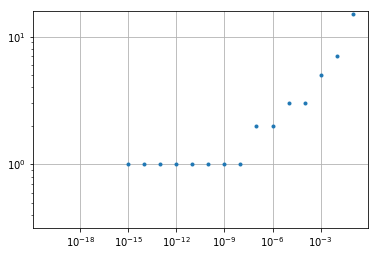

In [8]:
plt.figure()
plt.loglog(r_all, out_data[:, 1], '.')
plt.grid(True)
plt.ylim([10**(-0.5), np.max(out_data[:, 1]) + 1])
plt.show()

Explique cláramente por qué a medida que disminuye $r$ disminuye la cantidad de terminos significativos obtenidos.


Es claro ver que al tener valores de $r$ cada vez más bajos, nuestra suma requerirá poder representar valores en la mantisa cada vez más pequeños, eventualmente nos encontraremos con valores tan pequeños que saldrán de la mantisa, siendo víctimas de la regla del redondeo.

En el siguiente gráfico se podrá ver cómo se explica la perdida de nuestra representación, en términos de cada iteración.

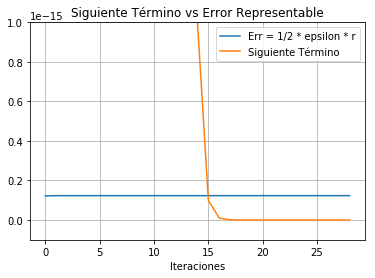

In [118]:
import sys
epsilon = sys.float_info.epsilon

def my_partial_geometric_series_2(r, M):
    sum_before = 1.0
    for i in np.arange(1, M):
        sum_before += r**i
        yield [sum_before, i - 1]

r = r_all[0]
results = list(my_partial_geometric_series_2(r, 30))

terms = []
errs = []
for t, i in results:
    terms.append(r**(i + 1))
    errs.append(t * epsilon / 2)

plt.figure()
plt.grid(True)
plt.plot(np.arange(29), errs, label='Err = 1/2 * epsilon * r')
plt.plot(np.arange(29), terms, label='Siguiente Término')
plt.ylim(- 1e-16, 1e-15)
plt.title('Siguiente Término vs Error Representable')
plt.legend()
plt.xlabel('Iteraciones')
plt.show()

En el gráfico anterior vemos que en la iteración $15$, con $r = 0.1$, corta al eje que nos indica si el error escalado permite representar los valores menores sumados, es decir:

$$|fl(x) - x| < \frac{1}{2} * \epsilon * x$$

Al tener valores sumados que son menores a este rango, no afectarán la suma final.

**C)** Explique la razón de por qué el loop indicado debe ejecutar el break. Utilice la función "to_binary" incluida en el jupyter notebook "03_floating_point_arithmetic" para entregar su justificación. Obtenga el menor valor de $X$ que ejecuta el break.

In [12]:
# Hint: Comenzando con X=1.0 se demorará mucho, piense primero, determine un buen X y luego ejecute el código.
X = 9007199254740991.0
a = X + 0.0
b = X + 1.0

while(True):
    a += 1.0
    b += 1.0
    if a == b:
        print('They are equal! Why?')
        break

They are equal! Why?


<div id='perdida' />
4. Perdida de Significancia
---------------------------

La **Pérdida de Significancia** ocurre cuando en un cálculo numérico muchos dígitos relevantes se cancelan, dada la aritmética de punto flotante finita ocupada por los computadores. Cuando un número es restado por otro número considerablemente parecido, efectos indeseados ocurren tales como la cancelación  y reducción de dígitos.

#### 1. Dada la función:

$$f(x) = \frac{1 - x}{ 1 + x} - \frac{1}{3x+1}$$

a) Grafique la función usando $x \in {[-10,10]}$ ¿Para que valores de x la función queda reducida a $0$?

In [100]:
def f(x):
    return (1 - x)/(1 + x) - 1/(3 * x + 1)
f = np.vectorize(f)

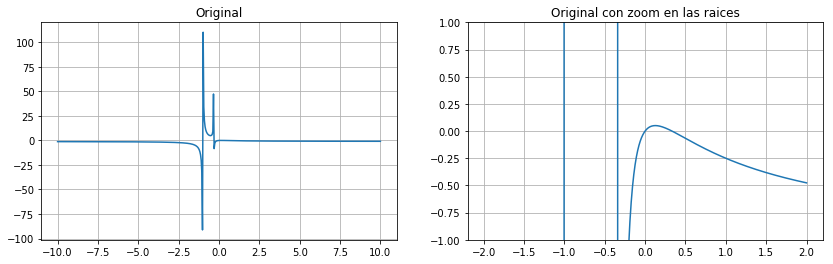

In [101]:
plt.figure(figsize=(14, 4))

xs = np.linspace(-10, 10, 500)
ys = f(xs)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.grid(True)
plt.plot(xs, ys)

xs = np.linspace(-2, 2, 500)
ys = f(xs)

plt.subplot(1, 2, 2)
plt.ylim(-1, 1)
plt.title("Original con zoom en las raices")
plt.grid(True)
plt.plot(xs, ys)

plt.show()

b) Usando $x = [10^{-1} , 10^{-2} , ... , 10^{-20}] $ , calcule los valores de f(x) ¿Que ocurre con los valores observados? ¿En que momento ocurre pérdida de significancia? Describa el origen de cancelación de digítos. 

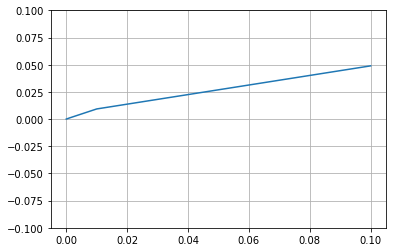

In [15]:
xs = np.logspace(-1, -20, 20)
ys = f(xs)

plt.figure()
plt.grid(True)
plt.ylim(-0.1, 0.1)
plt.plot(xs, ys)
plt.show()

c) Reescriba la función original para evitar el proceso de pérdida de significancia (hint: busqué un denominador común para ambas fracciones.)

In [40]:
def g(x):
    return (x - 3 * x**2)/(1 + 4 * x + 3 * x**2)
g = np.vectorize(g)

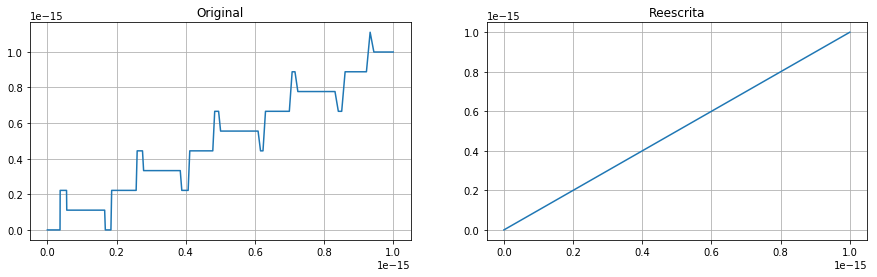

In [41]:
def plot(f, xs, title, grid):
    plt.subplot(1, 2, grid)
    plt.title(title)
    plt.grid(True)
    plt.plot(xs, f(xs))

xs = np.logspace(-15, -20, 1000)
plt.figure(figsize=(15, 4))
plot(f, xs, "Original", 1)
plot(g, xs, "Reescrita", 2)
plt.show()

Notamos que la función original, al perder precisión, nos presenta valores cercanos al resultado esperado, pero con errores, mientras que la función reescrita parece evitar estos errores (en la escala representada en el gráfico), lo que no significa que no pierda presición, si no que convenientemente pierde menos.

d) Analice la diferencia entre los resultados de la función $f(x)$ con la función reescrita en la pregunta anterior. Realice un gráfico que mida la diferencia entre los resultados del punto a) y c). Realice un análisis cualitativo y cuantitativo de los resultados.

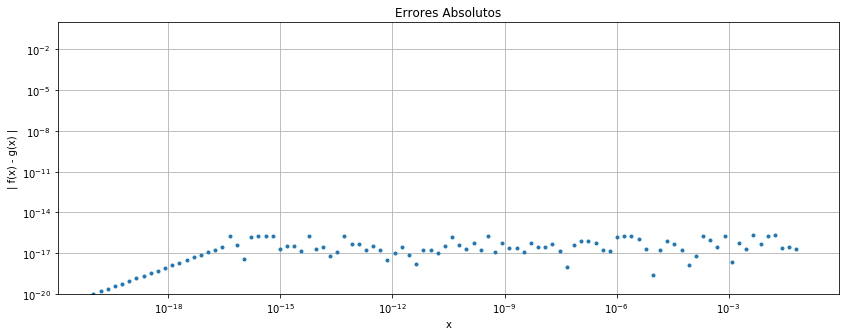

In [84]:
xs = np.logspace(-20, -1, 100)

ys1 = f(xs)
ys2 = g(xs)
errs = np.abs(ys1 - ys2)

#print("x".ljust(22) + " | " + "f(x)".ljust(22) + " | " + "g(x)".ljust(22) + " | " + "np.abs(f(x) - g(x))".ljust(20))
#for i, (v1, v2, err) in enumerate(zip(ys1, ys2, errs)):
#    print('%.20f | %.20f | %.20f | %.20f' % (xs[i], v1, v2, err))

plt.figure(figsize=(14, 5))
plt.title('Errores Absolutos')
plt.loglog(xs, errs, '.')
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('| f(x) - g(x) |')
plt.grid(True)
plt.show()

CONCLUSIÓN

#### 2. Para la siguiente función: 

$$g(x) = \frac{1 - \sec(x)}{\tan(x)^2} $$

a) Usando $x = [0,\frac{\pi}{4} ,\frac{\pi}{2}, \frac{3\pi}{4} , ... , 2\pi ]$ (intervalo de $0$ a $2\pi$ ) calcule los valores de esta función. Realice el mismo procedimiento del punto anterior.

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


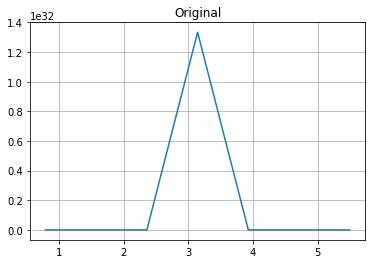

In [110]:
def g(x):
    #1 / (np.cos(x) + 1) - 1
    return (1 - 1 / np.cos(x))/(np.tan(x)**2)

g = np.vectorize(g)

xs = np.arange(0, 2 * np.pi, np.pi/4)
plt.figure(figsize=(14, 4))

ys = g(xs)

plt.figure()
plt.title("Original")
plt.grid(True)
plt.plot(xs, ys)
plt.show()